# Ensemble Kalman Filter Workflow

1. Available observation vector for $\vec{y_{k+1}}$, and calculate the observation ensemble from the directional uncertainties based on the wind speed and direction. To calculate the uncertainty for each point of the perimeter:
    1. Obtain the centroid $c_k = 1/M\sum{y_k}$ where $M$ is the number of points.
    2. Calculate vectors $\vec{v_k^m}$ for each point from the centroid to the point where $m$ is the $m^{th}$ point in the perimeter
    3. Obtain the wind speed and direction: $\vec{u_k}$ from the closest weather station to the centroid
    4. Uncertainty for each point $m$ is then $e_k^m = \alpha \left(1 - \vec{v_k^m} \cdot \vec{u_k}\right)$

2. Given a state vector $x_k$ and uncertainties around each point $P_k$, generate an ensemble 
$$X_k = (x_k^1, x_k^2, \cdots , x_k^N)$$
    1. For the first timepoint $k=0$, the state vector is the first observation $(x_0 = y_0)$, and the ensemble is obtained from directional uncertainties assigned based on the wind speed and direction
    2. **Question:** When creating the ensemble, do we preserve the mean $\overline{x_k}$?
    
3. From the ensemble $X_k$, advance for each state vector $X_{k+1} = F(X_k, u_k)$, where $u_k$ 

4. 

## Dependencies:

In [45]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

## Default Values

In [2]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

## Select a fire

```selected_fire``` variable holds the name of the fire selected. ```selected_fire = 'Maria2019'``` for now

In [3]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

unique_desc = usr.db.gdfignitionAll['description'].unique()
print(f'Available fires are {unique_desc}')

selected_fire = 'Maria2019'
print(f'{selected_fire} is selected.\n')
if (unique_desc == selected_fire).any():
    print(f'{selected_fire} is found!')
else:
    raise ValueError(f'{selected_fire} not found in possible fire descriptions: {unique_desc}')

Database interaction not yet implemented. Use pickle file for dataframes instead!
Available fires are ['Maria2019' 'River2021' 'Bridge2021']
Maria2019 is selected.

Maria2019 is found!


In [4]:
from shapely.geometry import MultiPolygon, Polygon
import numpy as np

class State:
    def __init__(self, geom):
        self.geom = geom
        
        # Initialize
        self.vertices = self.calculate_vertices()
        self.lengths = self.calculate_lengths()
    def calculate_vertices(self):
        geom = self.geom
        if isinstance(geom, MultiPolygon):
            geompoly = geom.geoms[0]
        elif isinstance(geom, Polygon):
            geompoly = geom

        return np.array((geompoly.exterior.coords))
    
    def calculate_lengths(self):
        return np.sqrt((np.diff(self.vertices, axis=0)**2).sum(axis=1))
    
    def calculate_vector(self):
        # Returns column vector of the vertices (x0, y0, x1, y1, ...)
        return self.vertices.reshape(len(self.vertices)*2, 1)
    
    

## Obtain the state vector

Initially use `k=0` observational error

In [5]:
observation = usr.db.gdfignition.iloc[0]
state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
igniteidx = observation.name
state_datetime = observation['datetime']

current_state = State(state_geom)

## Obtain wind conditions of the nearest weather station

### TODO : Obtain wind through pylaski API

In [6]:
windspeed = 10
winddirection = 90


## Calculate uncertainties based on wind conditions

In [7]:
# uncertainty in both x and y for each vertex
uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=windspeed)*np.sqrt(current_state.lengths.max())

In [8]:
def sample_geometry(current_state, uncertainties):
    
    maxlength = current_state.lengths.max()
    
    sampled_vertices = []
    for (x,y), sigma in zip(current_state.vertices, uncertainties):
        mu=0
        randx = random.gauss(mu, sigma)
        randy = random.gauss(mu, sigma)
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices).buffer(maxlength, join_style=1).buffer(-maxlength, join_style=1)
    

## Create an Ensemble for the first timepoint k=0

In [9]:
nsamples = 100

ignitions = {'igniteidx': [], 
             'filetype': [],
             'objectid': [],
             'filepath': [],
             'datetime': [],
             'description': [],
             'geometry': []}

time_estimator = TimeEstimator(nsamples)
for sample in range(nsamples):
    print(time_estimator.info_str(sample), end='\r', flush=True)
    
    ignitions['igniteidx'].append(uuid.uuid4().hex)
    ignitions['filetype'].append(observation['filetype'])
    ignitions['objectid'].append(f'{observation["objectid"]}E{sample:04d}')
    
    geometry = sample_geometry(current_state, uncertainties)
    if isinstance(geometry, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, geom in enumerate(geometry.geoms):
            if geom.area > max_area:
                max_area = geom.area
                max_area_idx = ix
        geometry = geometry.geoms[max_area_idx]
    
    ignitions['geometry'].append(geometry)
    
    ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{selected_fire}E{sample:04d}.shp')
    gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                     crs='EPSG:5070').to_file(ignitions['filepath'][-1])
    
    ignitions['datetime'].append(observation['datetime'])
    ignitions['description'].append(observation['description'])
    
usr.db.gdfignition = usr.db.gdfignition.append(gpd.GeoDataFrame(ignitions).set_index('igniteidx').set_crs(epsg=5070).to_crs(epsg=4326))
usr.db.gdfignition = usr.db.gdfignition.to_crs(epsg=5070)

/tmp/ipykernel_892/2609905624.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usr.db.gdfignition = usr.db.gdfignition.append(gpd.GeoDataFrame(ignitions).set_index('igniteidx').set_crs(epsg=5070).to_crs(epsg=4326))


#### Create each ignition in sequence

In [10]:
# fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
# gdfrow = usr.db.gdfignition.iloc[45]

# # for igniteidx, gdfrow in usr.db.gdfignition.iterrows():

# geom = usr.db.gdfignition.iloc[0]['geometry']
# x,y = geom.exterior.coords.xy
# ax.plot(x,y, 'b-')

# geom = gdfrow['geometry']
# if isinstance(geom, MultiPolygon):
#     geom = geom.geoms[0]

# x,y = geom.exterior.coords.xy
# ax.plot(x,y, 'r--')
    
# # ax.set_ylim(34.3, 34.34)
# # ax.set_xlim(-119.07, -119.02)

## Advance state vector in FARSITE

In [14]:
## obtain the igniteidx of the ignition
## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
compareidx = '9f82e870591748a9a8a01346d174f2a1'
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

In [15]:
inputData_lst = []
mainapi_lst = []
for igniteidx in ignitions['igniteidx']:
    inputData = {'description': selected_fire,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}
    
    mainapi_lst.append(usr.calculatePerimeters(inputData))

{'description': 'Maria2019', 'igniteidx': '412083db2bdd4fdd9e87214593be2e55', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '393d0e2c3b2240f5bcacf25076721985', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'c110b12081a44ddeb6ea7fc98b777859', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

In [16]:
# from multiprocessing import Pool

# numproc = 4
# pool = Pool(processes=numproc)

# Run for each FarsiteManual
for mainapi in mainapi_lst:
    # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
    mainapi.run_farsite()

# pool.close()
# pool.join()

Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00100/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0000.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00100/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00101/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0001.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00101/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00102/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0002.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00102/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00103/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0003.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00103/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00104/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0004.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00104/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00105/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0005.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00105/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00106/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0006.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00106/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00107/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0007.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00107/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00108/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0008.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00108/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00109/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0009.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00109/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00110/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0010.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00110/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00111/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0011.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00111/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00112/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0012.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00112/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00113/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0013.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00113/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00114/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0014.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00114/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00115/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0015.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00115/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00116/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0016.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00116/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00117/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0017.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00117/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00118/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0018.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00118/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00119/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0019.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00119/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00120/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0020.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00120/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00121/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0021.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00121/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00122/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0022.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00122/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00123/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0023.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00123/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00124/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0024.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00124/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00125/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0025.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00125/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00126/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0026.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00126/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00127/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0027.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00127/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00128/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0028.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00128/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00129/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0029.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00129/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00130/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0030.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00130/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00131/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0031.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00131/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00132/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0032.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00132/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00133/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0033.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00133/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00134/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0034.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00134/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00135/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0035.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00135/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00136/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0036.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00136/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00137/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0037.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00137/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00138/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0038.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00138/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00139/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0039.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00139/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00140/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0040.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00140/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00141/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0041.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00141/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00142/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0042.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00142/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00143/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0043.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00143/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00144/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0044.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00144/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00145/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0045.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00145/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00146/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0046.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00146/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00147/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0047.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00147/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00148/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0048.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00148/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00149/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0049.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00149/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00150/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0050.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00150/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00151/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0051.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00151/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00152/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0052.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00152/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00153/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0053.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00153/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00154/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0054.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00154/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00155/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0055.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00155/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00156/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0056.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00156/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00157/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0057.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00157/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00158/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0058.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00158/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00159/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0059.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00159/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00160/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0060.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00160/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00161/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0061.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00161/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00162/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0062.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00162/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00163/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0063.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00163/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00164/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0064.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00164/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00165/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0065.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00165/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00166/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0066.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00166/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00167/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0067.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00167/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00168/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0068.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00168/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00169/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0069.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00169/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00170/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0070.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00170/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00171/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0071.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00171/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00172/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0072.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00172/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00173/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0073.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00173/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00174/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0074.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00174/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00175/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0075.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00175/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00176/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0076.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00176/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00177/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0077.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00177/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00178/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0078.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00178/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00179/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0079.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00179/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00180/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0080.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00180/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00181/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0081.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00181/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00182/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0082.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00182/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00183/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0083.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00183/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00184/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0084.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00184/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00185/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0085.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00185/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00186/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0086.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00186/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00187/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0087.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00187/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00188/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0088.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00188/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00189/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0089.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00189/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00190/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0090.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00190/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00191/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0091.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00191/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00192/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0092.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00192/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00193/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0093.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00193/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00194/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0094.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00194/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00195/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0095.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00195/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00196/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0096.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00196/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00197/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0097.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00197/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00198/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0098.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00198/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 32).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221206/Run_00199/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0099.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221206/Run_00199/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


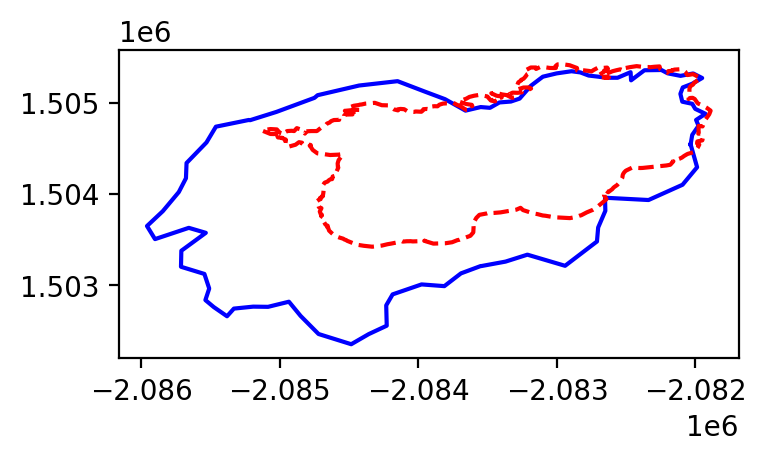

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
gdfrow = usr.db.gdfsimulation.iloc[5]

# for igniteidx, gdfrow in usr.db.gdfignition.iterrows():

geom = usr.db.gdfignition.iloc[1]['geometry']
x,y = geom.exterior.coords.xy
ax.plot(x,y, 'b-')

geom = gdfrow['geometry']
if isinstance(geom, MultiPolygon):
    geom = geom.geoms[0]

x,y = geom.exterior.coords.xy
ax.plot(x,y, 'r--')
    
# ax.set_ylim(34.3, 34.34)
# ax.set_xlim(-119.07, -119.02)

## Update the advanced state vector based on k=1 observations

#### Interpolate all the vertices

In [55]:
vertex_count = 0
for geom in ignitions['geometry']:
    if vertex_count < len(geom.exterior.coords):
        vertex_count = len(geom.exterior.coords)

interpolated_vertices = []
for geom in ignitions['geometry']:
    geom_state = State(geom)
    vertices = np.array(interpolate_perimeter(geom_state.calculate_vertices(), vertex_count))
    
    interpolated_vertices.append(vertices)
    
aligned_vertices = []

#### TODO: Vertices include an additional point when generated from geometry. Remove the repeat!

In [118]:
time_estimator = TimeEstimator(len(interpolated_vertices)-1)

minroll_lst = []
for i in range(len(interpolated_vertices)-1):
    print(time_estimator.info_str(i), end='\r', flush=True)
    
    left_vertices = interpolated_vertices[i]
    right_vertices = interpolated_vertices[i+1]
    
    
    # Cycle right_vertices
    l2perroll = []
    for roll in range(len(interpolated_vertices)-1):
        diff = left_vertices - right_vertices
        diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

        # Calculate diff^2 in
        l2perroll.append(diff2sum)
        
        right_vertices = np.roll(right_vertices,1, axis=0)
        
    minroll_lst.append(np.argmin(l2perroll))
    
aligned_vertices = [interpolated_vertices[0]]
for i in range(len(interpolated_vertices)-1):
    aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
## Check reverse direction too?

#### TODO: Check whether the aligned_vertices have the correct roll amount
1. Create matrices from the aligned_vertices, and form the $X_0$ ensemble state matrix
2. Using the observation $y_1$, update the state vector and obtain $X_1$